In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from statsmodels.tsa.seasonal import seasonal_decompose

In [38]:
#Load dataset
FILE = "Walmart.csv"
df = pd.read_csv(FILE)

df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values('Date')



In [43]:
if 'Date' not in df.columns or 'Weekly_Sales' not in df.columns:
    raise ValueError("Walmart.csv must include 'Date' and 'Weekly_Sales' columns.")

df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')
if df['Date'].isna().any():
    df['Date'] = pd.to_datetime(df['Date'].astype(str), errors='coerce')

if 'Store' not in df.columns:
    df['Store'] = 0
df = df[df['Weekly_Sales'] > 0].copy()

In [44]:
df = df.sort_values(['Store', 'Date']).reset_index(drop=True)
df['day'] = df['Date'].dt.day
df['month'] = df['Date'].dt.month
df['year'] = df['Date'].dt.year
df['weekofyear'] = df['Date'].dt.isocalendar().week.astype(int)
df['day_of_week'] = df['Date'].dt.dayofweek

In [45]:
grp = df.groupby('Store', group_keys=False)

for L in (1,2,3):
    df[f'lag{L}'] = grp['Weekly_Sales'].shift(L)

for W in (3,7,14):
    df[f'rollmean_{W}'] = grp['Weekly_Sales'].rolling(window=W, min_periods=1).mean().reset_index(level=0, drop=True)
    df[f'rollstd_{W}']  = grp['Weekly_Sales'].rolling(window=W, min_periods=1).std().reset_index(level=0, drop=True).fillna(0)
df = df.dropna(subset=['lag1','lag2','lag3']).reset_index(drop=True)
df['rolling_avg_4'] = df['Weekly_Sales'].rolling(window=4, min_periods=1).mean()


Running seasonal decomposition 


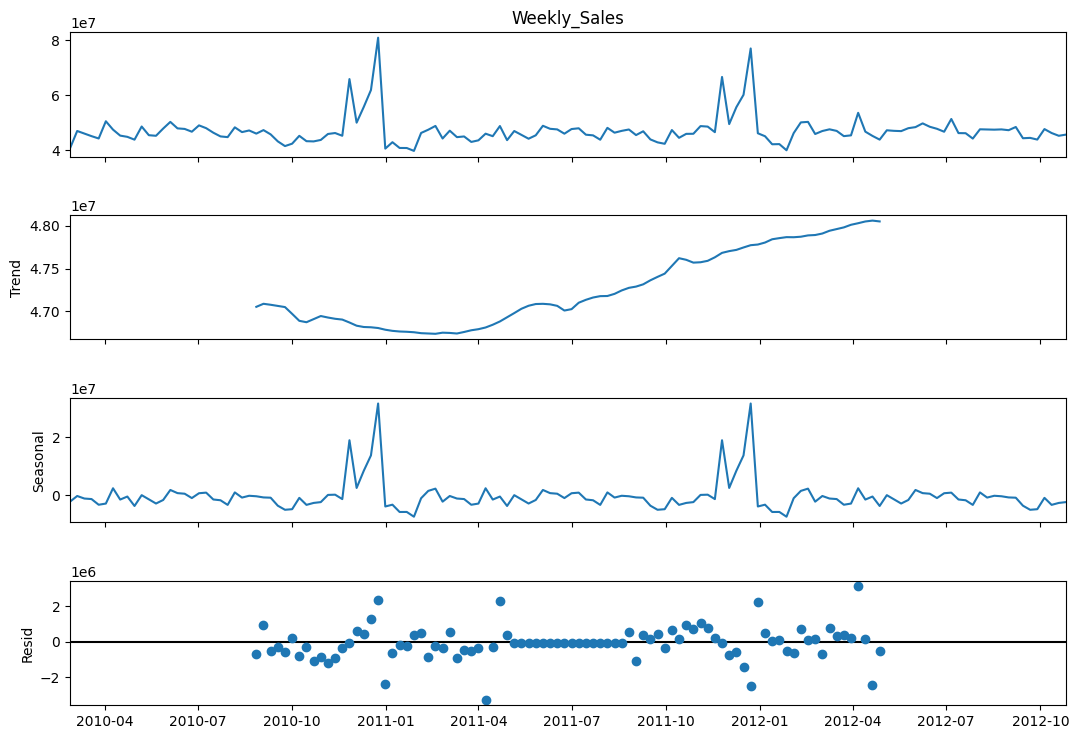

In [46]:
weekly_total = df.groupby('Date', as_index=True)['Weekly_Sales'].sum().sort_index()
if len(weekly_total) >= 104:
    print("Running seasonal decomposition ")
    res = seasonal_decompose(weekly_total, model='additive', period=52)
    fig = res.plot()
    fig.set_size_inches(12,8)
    plt.show()
else:
    print("Not enough points for seasonal decomposition")

In [47]:
FEATURES = [
    'day','month','year','weekofyear','day_of_week',
    'lag1','lag2','lag3',
    'rollmean_3','rollmean_7','rollmean_14',
    'rollstd_3','rollstd_7','rollstd_14',
    'Temperature','Fuel_Price','CPI','Unemployment'
]
FEATURES = [c for c in FEATURES if c in df.columns]

X = df[FEATURES].apply(pd.to_numeric, errors='coerce').fillna(0)
y = df['Weekly_Sales'].astype(float)

In [48]:
unique_dates = np.array(sorted(df['Date'].unique()))
cut = int(len(unique_dates) * 0.8)
cut_date = unique_dates[cut]

train_mask = df['Date'] < cut_date
test_mask  = df['Date'] >= cut_date

X_train, y_train = X.loc[train_mask], y.loc[train_mask]
X_test,  y_test  = X.loc[test_mask],  y.loc[test_mask]
dates_test = df.loc[test_mask, 'Date']

print(f"Train date range: {df.loc[train_mask,'Date'].min().date()} -> {df.loc[train_mask,'Date'].max().date()}")
print(f"Test  date range: {df.loc[test_mask,'Date'].min().date()} -> {df.loc[test_mask,'Date'].max().date()}")

Train date range: 2010-02-26 -> 2012-04-13
Test  date range: 2012-04-20 -> 2012-10-26


In [51]:
xgb_params = dict(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.8,
    reg_alpha=0.5,
    reg_lambda=1.0,
    objective='reg:squarederror',
    random_state=42
)

try:
    model = XGBRegressor(tree_method='gpu_hist', predictor='gpu_predictor', **xgb_params)
    model.fit(X_train, y_train)
    print("Trained XGBoost using GPU.")
except Exception as e:
    print("GPU unavailable or failed, falling back to CPU. Reason:", str(e))
    model = XGBRegressor(tree_method='hist', **xgb_params)
    model.fit(X_train, y_train)
    print("Trained XGBoost using CPU.")

Trained XGBoost using GPU.


In [55]:
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\nHoldout results :")
print(f"  MSE : {mse:,.2f}")
print(f"  RMSE: {rmse:,.2f}")
print(f"  MAE : {mae:,.2f}")
print(f"  R2  : {r2:.4f}")


Holdout results :
  MSE : 817,874,539.06
  RMSE: 28,598.51
  MAE : 19,795.28
  R2  : 0.9971


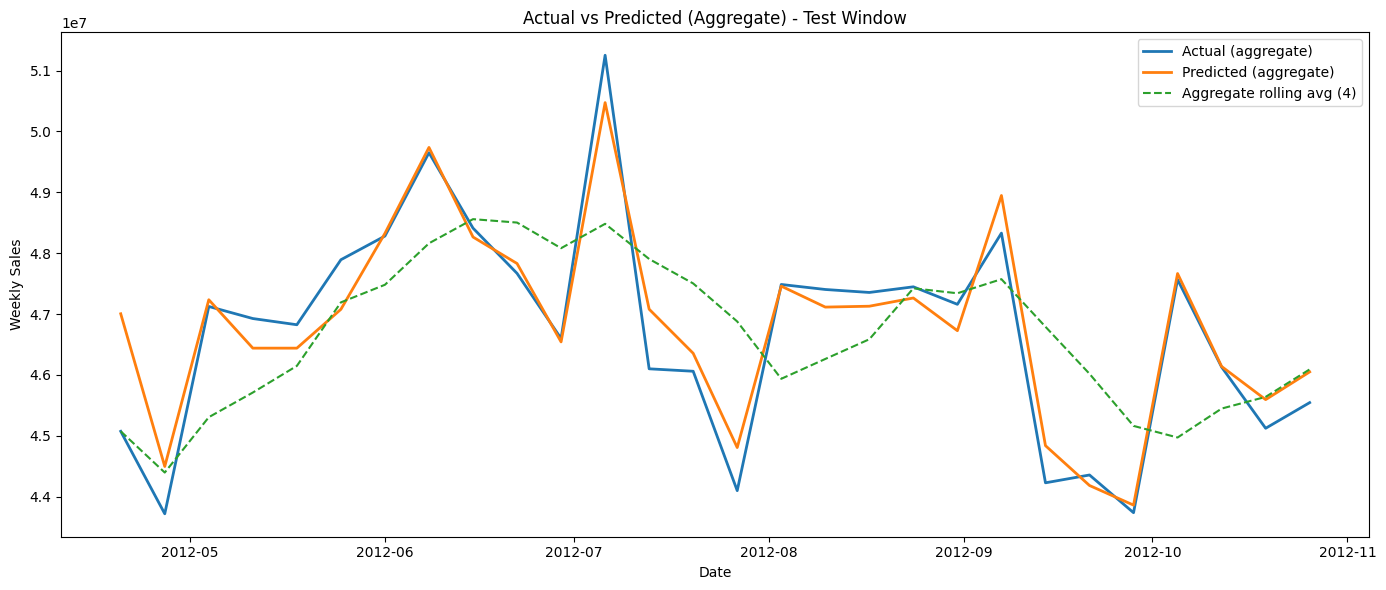

In [56]:
test_df = df.loc[test_mask, ['Date','Weekly_Sales']].copy().reset_index(drop=True)
test_df['pred'] = y_pred

agg = test_df.groupby('Date', as_index=False).agg(actual=('Weekly_Sales','sum'), pred=('pred','sum'))

plt.figure(figsize=(14,6))
plt.plot(agg['Date'], agg['actual'], label='Actual (aggregate)', linewidth=2)
plt.plot(agg['Date'], agg['pred'], label='Predicted (aggregate)', linewidth=2)
plt.plot(agg['Date'], agg['actual'].rolling(window=4, min_periods=1).mean(), label='Aggregate rolling avg (4)', linestyle='--')
plt.title('Actual vs Predicted (Aggregate) - Test Window')
plt.xlabel('Date'); plt.ylabel('Weekly Sales'); plt.legend(); plt.tight_layout(); plt.show()


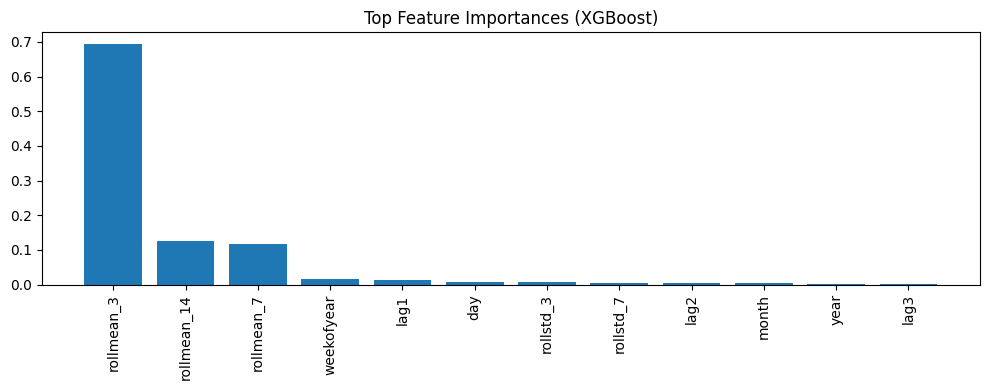


Next-week date: 2012-11-02  — Total forecasted Weekly Sales: 11,715,270.00


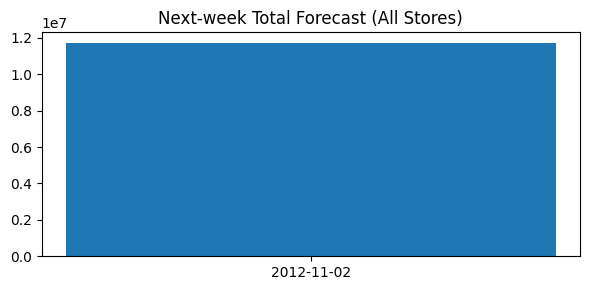

In [58]:
importances = model.feature_importances_
order = np.argsort(importances)[::-1]
topk = min(12, len(FEATURES))
plt.figure(figsize=(10,4))
plt.bar(range(topk), importances[order][:topk])
plt.xticks(range(topk), [FEATURES[i] for i in order[:topk]], rotation=90)
plt.title('Top Feature Importances (XGBoost)'); plt.tight_layout(); plt.show()


last_date = df['Date'].max()
next_date = last_date + pd.Timedelta(days=7)

last_rows = df.sort_values(['Store','Date']).groupby('Store', as_index=False).tail(1).copy()
future = last_rows.copy()
future['Date'] = next_date
future['day'] = future['Date'].dt.day
future['month'] = future['Date'].dt.month
future['year'] = future['Date'].dt.year
future['weekofyear'] = future['Date'].dt.isocalendar().week.astype(int)
future['day_of_week'] = future['Date'].dt.dayofweek

hist = df[['Store','Date','Weekly_Sales']].sort_values(['Store','Date']).copy()
for L in (1,2,3):
    hist[f'lag{L}'] = hist.groupby('Store')['Weekly_Sales'].shift(L)
for W in (3,7,14):
    hist[f'rollmean_{W}'] = hist.groupby('Store')['Weekly_Sales'].rolling(window=W, min_periods=1).mean().reset_index(level=0, drop=True)
latest = hist.groupby('Store', as_index=False).tail(1)

cols_to_merge = [c for c in latest.columns if c.startswith('lag') or c.startswith('rollmean') or c.startswith('rollstd')]
future = future.merge(latest[['Store'] + cols_to_merge], on='Store', how='left')

for c in FEATURES:
    if c not in future.columns:
        future[c] = 0
future_X = future[FEATURES].apply(pd.to_numeric, errors='coerce').fillna(0)

future['Forecast_NextWeek'] = model.predict(future_X)
total_forecast = future['Forecast_NextWeek'].sum()
print(f"\nNext-week date: {next_date.date()}  — Total forecasted Weekly Sales: {total_forecast:,.2f}")

plt.figure(figsize=(6,3))
plt.bar([str(next_date.date())], [total_forecast])
plt.title('Next-week Total Forecast (All Stores)'); plt.tight_layout(); plt.show()